# [모두의 주차장 앱 이용자 별 향후 이용건수 예측]

## 모두의 주차장은?
### 모바일을 통한 위치기반 주차장 정보 안내 및 주차공간 공유 서비스를 제공
홈페이지: https://www.moduparking.com/



### 데이터 정보
•	유저 가입 정보: id, 가입일

•	소비 행동 정보: 상품id, 점포 주소, 결제일, 결제건수

•	외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터
#### 해결과제: 데이터를 활용해 향후 한 달간의 이용건수를 예측하는 모델 개발

## 데이터 및 모듈 불러오기

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
np.random.seed(42)

In [3]:
traffic_data = pd.read_excel("2020교통량통합.xlsx")
weather_data = pd.read_csv("서울시_기상데이터.csv",encoding='cp949')
db_data = pd.read_csv("실전db.csv",encoding='cp949')


# 1. 외부데이터 전처리

### traffic data

해당일 전체 교통량이 교통량 데이터의 상위75%이상인 날을 교통이 혼잡한 날로 정의
<br>
교통이 혼잡한 날이면 1, 그렇지 않으면 0을 부여
<br>
daily로 groupby해 confusion수치를 활용

In [4]:
traffic_data.head()

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,...,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,...,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,632.0,457.0,295.0,236.0,279.0,...,2004.0,1929.0,2049.0,2140.0,2178.0,1654.0,1356.0,1260.0,1253.0,941.0
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,740.0,518.0,388.0,331.0,330.0,...,1837.0,1788.0,1588.0,1669.0,1530.0,1222.0,1143.0,1089.0,1039.0,791.0
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,533.0,424.0,297.0,230.0,209.0,...,1634.0,1673.0,1494.0,1429.0,1288.0,1035.0,987.0,884.0,803.0,564.0


In [5]:
traffic_data['total_traffic']=traffic_data.drop(['지점명','지점번호','방향','구분'],axis=1).iloc[:,1:].sum(axis=1)

In [6]:
traffic_data['total_traffic'].describe()

count     98820.000000
mean      33194.933050
std       24722.484349
min           0.000000
25%       17095.000000
50%       27911.000000
75%       42715.000000
max      145022.000000
Name: total_traffic, dtype: float64

In [7]:
traffic_data['confusion'] = list(map(int,traffic_data['total_traffic']>=42715))

In [10]:
daily_traffic = traffic_data.groupby('DATE').sum()
daily_traffic

,0시,1시,2시,3시,4시,5시,6시,7시,8시,9시,...,16시,17시,18시,19시,20시,21시,22시,23시,total_traffic,confusion
DATE,,,,,,,,,,,,,,,,,,,,,
2020-01-01,266533.0,296321.0,185636.0,134134.0,114799.0,125439.0,153618.0,177253.0,229955.0,271736.0,...,465493.0,440349.0,397753.0,372566.0,369655.0,343421.0,271340.0,185353.0,7347299.0,45
2020-01-02,128132.0,85712.0,64405.0,61816.0,102125.0,228184.0,417027.0,543584.0,576058.0,531913.0,...,537179.0,553531.0,550529.0,482317.0,416175.0,405076.0,359995.0,275395.0,9326734.0,68
2020-01-03,205548.0,153871.0,114252.0,96035.0,119189.0,223213.0,398420.0,538560.0,585920.0,548984.0,...,554737.0,564720.0,554247.0,515284.0,464737.0,440925.0,407617.0,328408.0,9998638.0,79
2020-01-04,257111.0,203631.0,164033.0,133204.0,137314.0,201180.0,281633.0,320162.0,417084.0,489365.0,...,535347.0,539571.0,496455.0,424779.0,401285.0,400037.0,353366.0,274282.0,9198233.0,66
2020-01-05,215442.0,164669.0,126931.0,100601.0,94797.0,118228.0,166274.0,205482.0,295470.0,396652.0,...,509879.0,487306.0,442948.0,393968.0,385019.0,357217.0,290775.0,206582.0,7868358.0,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,97461.0,65825.0,47251.0,37511.0,39924.0,66932.0,111260.0,142846.0,184457.0,249139.0,...,411129.0,387662.0,333651.0,293911.0,289518.0,268385.0,190265.0,131854.0,5606406.0,33
2020-12-28,86484.0,58691.0,48612.0,50032.0,84219.0,211277.0,394199.0,500626.0,518056.0,485182.0,...,510515.0,505339.0,491622.0,441868.0,386295.0,364670.0,239431.0,167271.0,8389535.0,62
2020-12-29,116057.0,79292.0,61207.0,57247.0,81373.0,187458.0,368849.0,492547.0,523080.0,494825.0,...,506981.0,504961.0,494863.0,446830.0,398213.0,379085.0,250498.0,175816.0,8523717.0,64


### weather data

In [8]:
weather_data.head()

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1
2,108,2020-01-01 3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1
3,108,2020-01-01 4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0
4,108,2020-01-01 5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0


In [9]:
weather_data['일시']=pd.to_datetime(weather_data['일시'])

In [10]:
 #시간데이터를 없애고 년/월/일 까지만 표시한 뒤 날짜가 같은 데이터를 묶을 예정
for i in range(len(weather_data['일시'])):
    weather_data['일시'][i] = weather_data['일시'][i].date()

<ipython-input-10-4be65a222d79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data['일시'][i] = weather_data['일시'][i].date()


In [11]:
weather_data.head()

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1
2,108,2020-01-01,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1
3,108,2020-01-01,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0
4,108,2020-01-01,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0


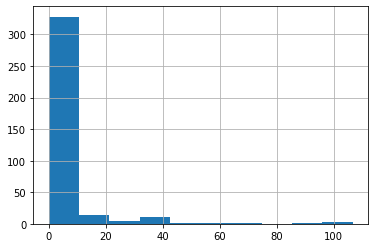

In [12]:
weather_daily = weather_data.groupby('일시').sum()
weather_daily['강수량'].hist()

일반적으로 1시간에 30mm 이상이나 하루에 80mm 이상의 비가 내릴 때 이를 집중호우로 정의한다

In [13]:
#bad_weather1 = weather_data[weather_data['강수량']>30]['일시']

In [14]:
bad_weather2 = weather_daily[weather_daily['강수량']>80].index

대설주의보는 하루 신적설이 5cm이상일 때

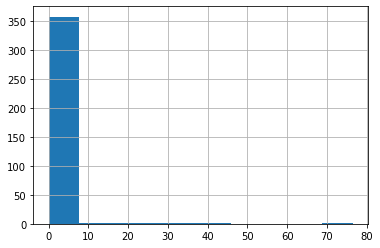

In [15]:
weather_daily = weather_data.groupby('일시').sum()
weather_daily['적설량'].hist()

In [16]:
bad_weather3 = weather_daily[weather_daily['적설량']>5].index #여기서의 적설량이 정확한 대설주의보 기준과 일치하지는 않지만 그냥 사용하기로 함

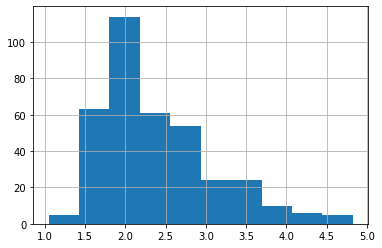

In [17]:
weather_daily = weather_data.groupby('일시').mean() #풍속은 sum이 의미없다 생각해 mean으로 사용
weather_daily['풍속'].hist()

In [18]:
weather_daily['풍속'].describe()

count    366.000000
mean       2.376998
std        0.705684
min        1.045833
25%        1.870833
50%        2.183333
75%        2.733333
max        4.825000
Name: 풍속, dtype: float64

In [19]:
bad_weather4 = weather_daily[weather_daily['풍속']>4].index

In [20]:
weather_daily['bad_weather'] = [False]*len(weather_daily.index) #더미 column생성

In [21]:
bad_weather = list(set(list(bad_weather4)+list(bad_weather3)+ list(bad_weather2)))

In [22]:
for i in range(len(bad_weather)):
    weather_daily[weather_daily.index == bad_weather[i]]['bad_weather'] = True


<ipython-input-22-4d6f4fd69da5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_daily[weather_daily.index == bad_weather[i]]['bad_weather'] = True


In [23]:
weather_daily.loc['2020-01-01']

지점                   108
기온              -2.54348
강수량                0.025
풍속               1.15217
습도               62.7391
일조시간           0.0727273
적설량                    0
지면온도           -0.917391
지중온도             2.85652
bad_weather        False
Name: 2020-01-01 00:00:00, dtype: object

In [24]:
aa = weather_daily.copy()
for i in range(len(bad_weather)):
    aa[aa.index == bad_weather[i]] = aa[weather_daily.index == bad_weather[i]].replace(False,True)

In [25]:
aa['bad_weather'] = list(map(int,(aa['bad_weather'])))

In [26]:
out_data = pd.concat([pd.DataFrame(aa['bad_weather']),pd.DataFrame(daily_traffic['confusion'])],axis=1)

In [27]:
out_data.head() #아래에서 정제된 db_data에 합칠 예정

,bad_weather,confusion
2020-01-01,0,45
2020-01-02,0,68
2020-01-03,0,79
2020-01-04,0,66
2020-01-05,0,51


# 2. DB데이터 살펴보기 

In [28]:
db_data.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [29]:
#datetime으로 변환
db_data['DATE'] = pd.to_datetime(db_data['DATE'])
db_data['JOIN_DATE'] = pd.to_datetime(db_data['JOIN_DATE'])


In [30]:
#한달간 이용건수를 예측해야 하기 때문에 month데이터만 따로 추가
lst = []
for i in db_data['DATE']:
    lst.append(i.month)
db_data['MONTH'] = lst


In [31]:
#STORE_ID는 고유값이기 때문에 문자로 변환
db_data['STORE_ID'] = list(map(str,db_data['STORE_ID']))

In [32]:
#COUNT,STORE_ID,AD1의 종류는 다양하다
print(len(set(db_data['COUNT'])))
print(len(set(db_data['STORE_ID'])))
print(len(set(db_data['AD1'])))

56
1061
85


In [33]:
#D_TYPE과 GOODS_TYPE은 범주가 적어 one-hot encoding 실시할 예정
print(set(db_data['D_TYPE']))
print(set(db_data['GOODS_TYPE']))

{'AA', 'BB', 'CC'}
{'B', 'D', 'A', 'C'}


## D_TYPE,AD1이 무엇을 의미하는 게 무엇일까? 
### 팀원들과의 회의를 통해 다음을 추론함
<br>
1. D_TYPE: 구매타입(n시간권/당일권/월정액권)
<br>
2. AD1은 주소(GN -> 강남)
<br>
3. JOIN_DATE가 1970인 데이터는 가입일이 없는 데이터가 아닐까

# db_data 살펴보기


In [34]:
#데이터 살펴보기
db_data.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,1
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,1
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,1
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,1


# 데이터 살펴보기

## USER_ID를 기준으로 데이터 살펴보기
* 하나 이상의 거래를 한 고객을 뽑아서 눈으로 살펴보자

In [35]:
#고객별로 몇개의 거래를 했는지
db_data['USER_ID'].value_counts() #value_counts(): 기억했다가 다음에 써먹으면 좋을 유용한 함수

999665     366
591610     244
1355841    235
1407916    222
1224426    222
          ... 
586251       1
1575444      1
1573397      1
1591836      1
30735        1
Name: USER_ID, Length: 165425, dtype: int64

In [36]:
db_data[db_data['USER_ID'] == 33314] #예시1 - 임의로 찾아본 고객

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1
235563,33314,2014-11-20,BB,220077,C,2020-05-01,1,JRR,5
239229,33314,2014-11-20,BB,220914,A,2020-05-03,1,GS,5


In [37]:
db_data[db_data['USER_ID'] == 999665] #예시2 - 거래가 가장 많은 고객(매일 거래했다고 추정됨)

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR,1
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN,1
3121,999665,2018-12-16,CC,181832,A,2020-01-03,7,SC,1
5034,999665,2018-12-16,CC,109223,A,2020-01-04,28,MP,1
6919,999665,2018-12-16,CC,104916,A,2020-01-05,14,GN,1
...,...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,CC,2428,A,2020-12-27,17,CY,12
868847,999665,2018-12-16,CC,109267,A,2020-12-28,24,J,12
871562,999665,2018-12-16,CC,90193,C,2020-12-29,23,GW,12
874317,999665,2018-12-16,CC,220797,D,2020-12-30,40,GS,12


# 3. 피처추가

### 1. 유저별 한달 총 이용건수 변수 만들기
* USER_ID로 묶은 데이터를 MONTH를 기준으로 한번 더 묶은 데이터프래임에서 COUNT값의 합계 구하기

In [38]:
db_data.drop('STORE_ID',axis=1).groupby(['USER_ID','MONTH']).sum() #월별 고객의 이용건수

COUNT
USER_ID MONTH       
224     1          1
        12         1
232     1          4
        2          2
        3          2
...              ...
1830551 12         1
1830570 12         1
1830580 12         1
1830589 12         1
1830598 12         1

[375429 rows x 1 columns]

In [39]:
q = db_data.drop('STORE_ID',axis=1).groupby(['USER_ID','MONTH']).sum().sort_values(by=['COUNT'],ascending=False)
print(q)

               COUNT
USER_ID MONTH       
999665  11      1189
        10      1019
        12       865
        9        785
        8        769
...              ...
1172500 3          1
        7          1
        9          1
        11         1
1830598 12         1

[375429 rows x 1 columns]


In [40]:
# q데이터가 많이 이상하다
#0. 확인해보니 USER_ID,MONTH가 INDEX화 되어있는 상태
#1. COUNT를 USER_ID,MONTH와 같은줄로 내린 뒤 이를 key로 묶고
#2. USER_ID의 빈 값을 채워넣어야 할 것 같다
q['USER_ID'] = [x[0] for x in q.index]
q['MONTH'] = [x[1] for x in q.index]
q.index = range(len(q))
print(q)

        COUNT  USER_ID  MONTH
0        1189   999665     11
1        1019   999665     10
2         865   999665     12
3         785   999665      9
4         769   999665      8
...       ...      ...    ...
375424      1  1172500      3
375425      1  1172500      7
375426      1  1172500      9
375427      1  1172500     11
375428      1  1830598     12

[375429 rows x 3 columns]


In [41]:
# q데이터의 USER_ID와 MONTH와 일치하는 db_data에다가 COUNT를 붙인다
merged_data = pd.merge(db_data,q,how='left',on=['USER_ID','MONTH']) #count_y가 내가 타겟으로 하는 변수
merged_data.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT_x,AD1,MONTH,COUNT_y
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,1,1
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,1,1
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1,1
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,1,5
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,1,1


In [42]:
#칼럼명 변경
merged_data.rename(columns = {'COUNT_x' : 'DAILY_COUNT'}, inplace = True)
merged_data.rename(columns = {'COUNT_y' : 'MONTH_TOTAL_COUNT'}, inplace = True)

In [43]:
merged_data.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,DAILY_COUNT,AD1,MONTH,MONTH_TOTAL_COUNT
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,1,1
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,1,1
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1,1
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,1,5
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,1,1


In [44]:
#merge 잘됐는지 확인
merged_data[merged_data['USER_ID'] == 37001]

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,DAILY_COUNT,AD1,MONTH,MONTH_TOTAL_COUNT
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,1,5
16354,37001,2014-12-04,BB,190223,A,2020-01-11,2,CY,1,5
27309,37001,2014-12-04,BB,28018,B,2020-01-17,1,JRR,1,5
42907,37001,2014-12-04,BB,220557,A,2020-01-26,1,YO,1,5
77365,37001,2014-12-04,BB,82429,B,2020-02-14,1,GN,2,1
117746,37001,2014-12-04,BB,82429,B,2020-03-06,1,GN,3,6
133823,37001,2014-12-04,BB,106190,A,2020-03-14,1,YD,3,6
135762,37001,2014-12-04,BB,106129,A,2020-03-15,2,J,3,6
160857,37001,2014-12-04,BB,92403,B,2020-03-27,1,J,3,6
165303,37001,2014-12-04,BB,92403,A,2020-03-29,1,J,3,6


In [45]:
#MONTH_TOTAL_COUNT 높은순서로 정렬해보자 (중복은 표시안되게)
merged_data.sort_values(by='MONTH_TOTAL_COUNT',ascending=False)[
    ~merged_data.sort_values(#~: boolean series를 반대로 만들어 주는 기능
        by='MONTH_TOTAL_COUNT',ascending=False #TARGET순으로 내림차순
    )['USER_ID'].duplicated() 
].head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,DAILY_COUNT,AD1,MONTH,MONTH_TOTAL_COUNT
758069,999665,2018-12-16,CC,220764,A,2020-11-16,34,CY,11,1189
580707,1514190,2020-03-06,AA,220607,A,2020-09-15,11,GN,9,130
560325,1336281,2019-10-02,AA,109423,A,2020-09-07,3,J,9,82
743722,1683685,2020-09-09,AA,223625,A,2020-11-11,3,SOD,11,73
766108,1737698,2020-10-21,BB,220848,C,2020-11-18,4,GN,11,73


* 996665고객은 outlier로 제거해야 할까?

## merged데이터로 간단한 EDA

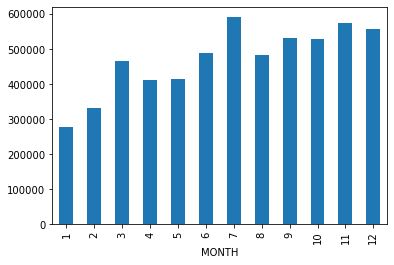

In [46]:
merged_data.groupby("MONTH").sum()['MONTH_TOTAL_COUNT'].plot.bar()#1월과 2월이 특히 낮다

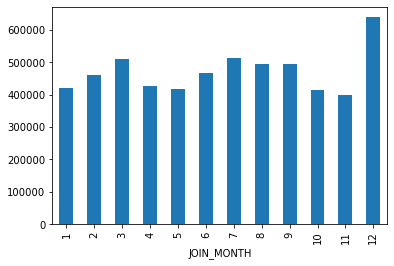

In [47]:
lst = []
for i in merged_data['JOIN_DATE']:
    lst.append(i.month)
merged_data['JOIN_MONTH'] = lst

merged_data.groupby("JOIN_MONTH").sum()['MONTH_TOTAL_COUNT'].plot.bar() #12월이 특히 높다

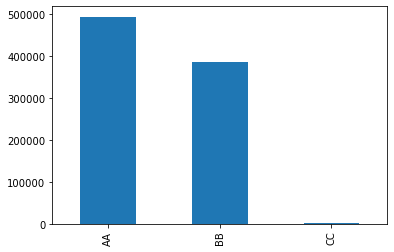

In [48]:
merged_data['D_TYPE'].value_counts().plot.bar() #CC가 적다

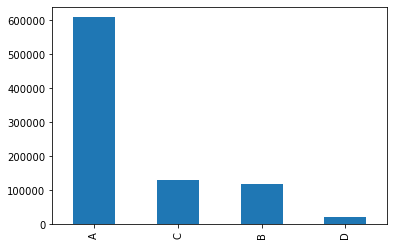

In [49]:
merged_data['GOODS_TYPE'].value_counts().plot.bar() #A가 많다

### 2. 요일값 추가

In [50]:
merged_data['week'] = ''
lst = []
for i in range(len(merged_data['week'])):
    lst.append(merged_data['DATE'][i].weekday())
merged_data['week'] = lst

In [51]:
merged_data.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,DAILY_COUNT,AD1,MONTH,MONTH_TOTAL_COUNT,JOIN_MONTH,week
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,1,1,1,2
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,1,1,2,2
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1,1,11,2
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,1,5,12,2
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,1,1,12,2


### 3. Traffic과 Weather에서 유의미한 값을 db_data에 추가

In [52]:
out_data['DATE']=out_data.index
out_data.head()

,bad_weather,confusion,DATE
2020-01-01,0,45,2020-01-01
2020-01-02,0,68,2020-01-02
2020-01-03,0,79,2020-01-03
2020-01-04,0,66,2020-01-04
2020-01-05,0,51,2020-01-05


In [53]:
merged_data = pd.merge(merged_data,out_data,on='DATE')

### 4. D_TYPE,GOODS_TYPE을 one-hot encoding 

In [54]:
#참고자료: http://growthj.link/python-%EC%9B%90-%ED%95%AB-%EC%9D%B8%EC%BD%94%EB%94%A9one-hot-encoding-%EC%A0%95%EB%A6%AC-get_dummies/
encoded_data = pd.get_dummies(data = merged_data,columns = ['D_TYPE'])
encoded_data = pd.get_dummies(data = encoded_data,columns = ['GOODS_TYPE'])
encoded_data = pd.get_dummies(data = encoded_data,columns = ['week'])
encoded_data

,USER_ID,JOIN_DATE,STORE_ID,DATE,DAILY_COUNT,AD1,MONTH,MONTH_TOTAL_COUNT,JOIN_MONTH,bad_weather,...,GOODS_TYPE_B,GOODS_TYPE_C,GOODS_TYPE_D,week_0,week_1,week_2,week_3,week_4,week_5,week_6
0,2858,2014-01-07,1892,2020-01-01,1,GN,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
1,5647,2014-02-14,182009,2020-01-01,1,J,1,1,2,0,...,0,0,0,0,0,1,0,0,0,0
2,33314,2014-11-20,82431,2020-01-01,1,SC,1,1,11,0,...,0,0,0,0,0,1,0,0,0,0
3,37001,2014-12-04,725,2020-01-01,1,MP,1,5,12,0,...,0,1,0,0,0,1,0,0,0,0
4,37819,2014-12-07,220691,2020-01-01,1,JRR,1,1,12,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,219886,2020-12-31,1,GN,12,1,12,0,...,1,0,0,0,0,0,1,0,0,0
879267,1830570,2020-12-31,82433,2020-12-31,1,CY,12,1,12,0,...,1,0,0,0,0,0,1,0,0,0
879268,1830580,2020-12-31,92020,2020-12-31,1,JRR,12,1,12,0,...,1,0,0,0,0,0,1,0,0,0
879269,1830589,2020-12-31,92437,2020-12-31,1,J,12,1,12,0,...,1,0,0,0,0,0,1,0,0,0


# 4. 모델 baseline 생성

In [55]:
train_data = encoded_data.query('DATE<20201001')
test_data = encoded_data.query('DATE>=20201001') #datetime을 query로 부를 경우에는 2020-01-01이 아니라 20200101로 넣어야 되는구나

In [56]:
train_data.head()

,USER_ID,JOIN_DATE,STORE_ID,DATE,DAILY_COUNT,AD1,MONTH,MONTH_TOTAL_COUNT,JOIN_MONTH,bad_weather,...,GOODS_TYPE_B,GOODS_TYPE_C,GOODS_TYPE_D,week_0,week_1,week_2,week_3,week_4,week_5,week_6
0,2858,2014-01-07,1892,2020-01-01,1,GN,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
1,5647,2014-02-14,182009,2020-01-01,1,J,1,1,2,0,...,0,0,0,0,0,1,0,0,0,0
2,33314,2014-11-20,82431,2020-01-01,1,SC,1,1,11,0,...,0,0,0,0,0,1,0,0,0,0
3,37001,2014-12-04,725,2020-01-01,1,MP,1,5,12,0,...,0,1,0,0,0,1,0,0,0,0
4,37819,2014-12-07,220691,2020-01-01,1,JRR,1,1,12,0,...,0,1,0,0,0,1,0,0,0,0


In [57]:
#Y값, 범주형 데이터, 날짜형 데이터 삭제
train_X = train_data.drop(['DAILY_COUNT','STORE_ID','AD1','JOIN_DATE','DATE'],axis=1)
test_X = test_data.drop(['DAILY_COUNT','STORE_ID','AD1','JOIN_DATE','DATE'],axis=1)
train_X.head()

,USER_ID,MONTH,MONTH_TOTAL_COUNT,JOIN_MONTH,bad_weather,confusion,D_TYPE_AA,D_TYPE_BB,D_TYPE_CC,GOODS_TYPE_A,GOODS_TYPE_B,GOODS_TYPE_C,GOODS_TYPE_D,week_0,week_1,week_2,week_3,week_4,week_5,week_6
0,2858,1,1,1,0,45,1,0,0,1,0,0,0,0,0,1,0,0,0,0
1,5647,1,1,2,0,45,0,1,0,1,0,0,0,0,0,1,0,0,0,0
2,33314,1,1,11,0,45,0,1,0,1,0,0,0,0,0,1,0,0,0,0
3,37001,1,5,12,0,45,0,1,0,0,0,1,0,0,0,1,0,0,0,0
4,37819,1,1,12,0,45,1,0,0,0,0,1,0,0,0,1,0,0,0,0


In [58]:
train_Y = train_data['DAILY_COUNT']
test_Y = test_data['DAILY_COUNT']

train_Y.head()

0    1
1    1
2    1
3    1
4    1
Name: DAILY_COUNT, dtype: int64

# Mean_Absolute_Error

In [ ]:
#mae가 O(N^2)이라고는 하는데 너무 오래걸리는데?
#clf = RandomForestRegressor(criterion='mae')
#clf.fit(train_X,train_Y)

# Mean_Squared_Error

In [59]:
clf2 = RandomForestRegressor(n_estimators=20, max_depth=5,criterion='mse')
clf2.fit(train_X,train_Y)

RandomForestRegressor(max_depth=5, n_estimators=20)

In [60]:
#predict1 = clf.predict(test_X)
predict2 = clf2.predict(test_X)
#print(mean_absolute_error(test_Y,predict1))
print(mean_squared_error(test_Y,predict2))

0.09374070285997203
